In [ ]:
# Skip it
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/DS')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
file_path = "automobile.dat"

with open(file_path, 'r') as file:
    lines = file.readlines()

data_start = lines.index('@data\n') + 1
data_lines = lines[data_start:]

input_line = next(line for line in lines if line.startswith('@inputs'))
columns = input_line.split('@inputs')[1].strip().split(', ') + ['Symboling']

df = pd.DataFrame(
    [line.strip().split(',') for line in data_lines],
    columns=columns
)

df.replace('?', pd.NA, inplace=True)

numeric_columns = ['Normalized-losses', 'Wheel-base', 'Length', 'Width', 'Height', 'Curb-weight',
                   'Engine-size', 'Bore', 'Stroke', 'Compression-ratio', 'Horsepower', 'Peak-rpm',
                   'City-mpg', 'Highway-mpg', 'Price', 'Symboling']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

print(df.head())

   Normalized-losses        Make Fuel-type Aspiration Num-of-doors Body-style  \
0              168.0      toyota       gas        std          two      sedan   
1              113.0       mazda       gas        std         four      sedan   
2               87.0      toyota       gas        std          two  hatchback   
3              125.0  mitsubishi       gas        std         four      sedan   
4              148.0       dodge       gas      turbo         <NA>      sedan   

  Drive-wheels Engine-location  Wheel-base  Length  ...  Fuel-system  Bore  \
0          rwd           front        94.5   168.7  ...         2bbl  3.19   
1          fwd           front        93.1   166.8  ...         2bbl  3.08   
2          fwd           front        95.7   158.7  ...         2bbl  3.05   
3          fwd           front        96.3   172.4  ...         2bbl  3.35   
4          fwd           front        93.7   157.3  ...         mpfi  3.03   

   Stroke Compression-ratio Horsepower  Peak

In [ ]:
print(len(df))

205


# Exploratory Data Analysis

In [ ]:
# check for missing values
print(df.isnull().sum())

Normalized-losses    41
Make                  0
Fuel-type             0
Aspiration            0
Num-of-doors          2
Body-style            0
Drive-wheels          0
Engine-location       0
Wheel-base            0
Length                0
Width                 0
Height                0
Curb-weight           0
Engine-type           0
Num-of-cylinders      0
Engine-size           0
Fuel-system           0
Bore                  4
Stroke                4
Compression-ratio     0
Horsepower            2
Peak-rpm              2
City-mpg              0
Highway-mpg           0
Price                 4
Symboling             0
dtype: int64


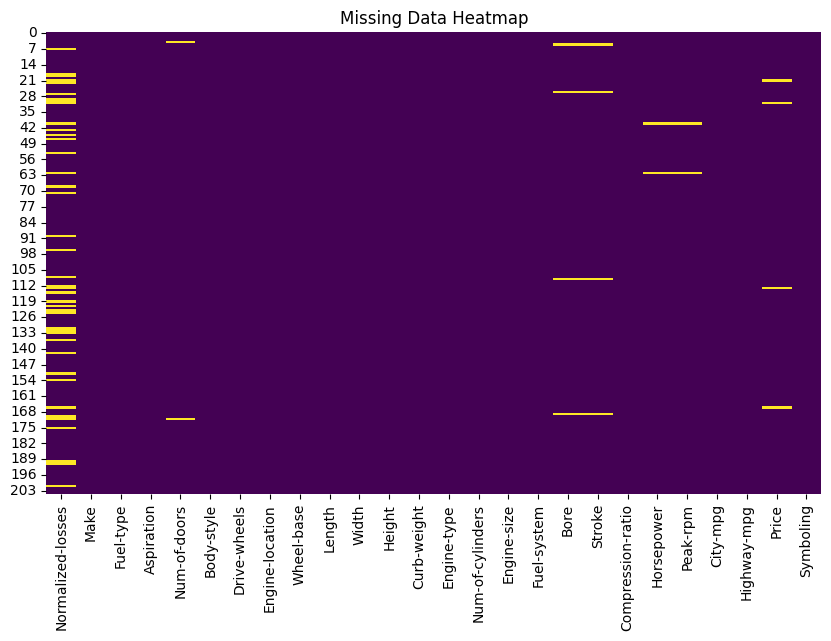

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [ ]:
df_without_na = df.dropna(inplace=False)

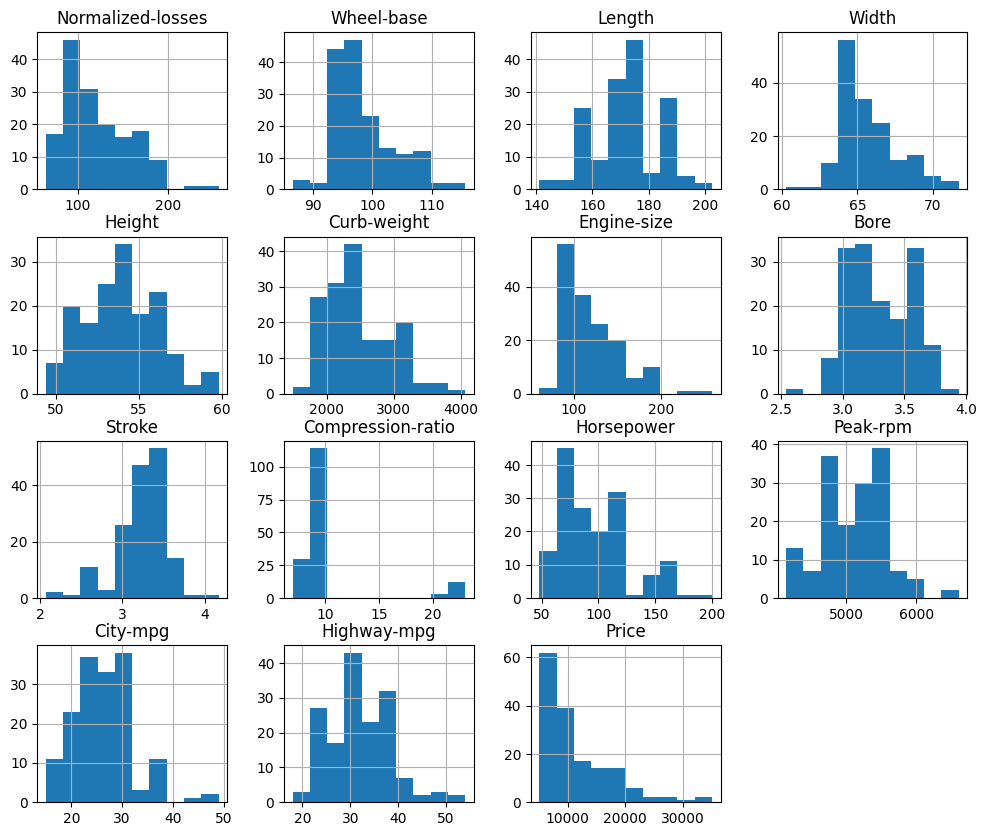

In [ ]:
numerical_columns = ['Normalized-losses', 'Wheel-base', 'Length', 'Width', 'Height', 'Curb-weight',
                   'Engine-size', 'Bore', 'Stroke', 'Compression-ratio', 'Horsepower', 'Peak-rpm',
                   'City-mpg', 'Highway-mpg', 'Price']
df_without_na[numerical_columns].hist(figsize=(12, 10))
plt.show()

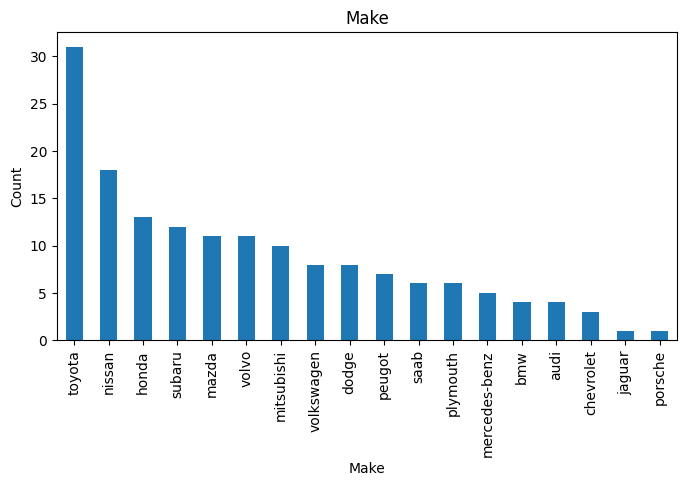

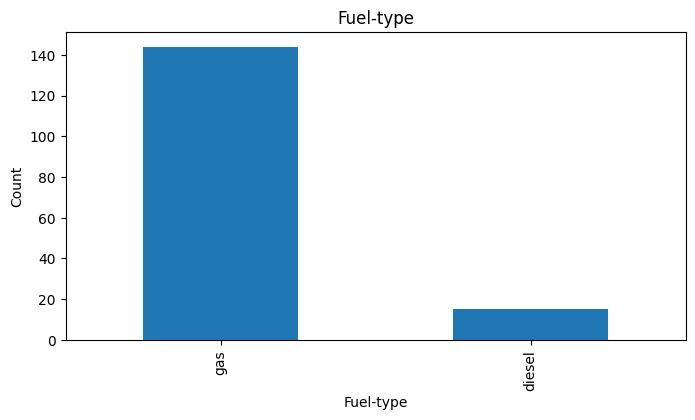

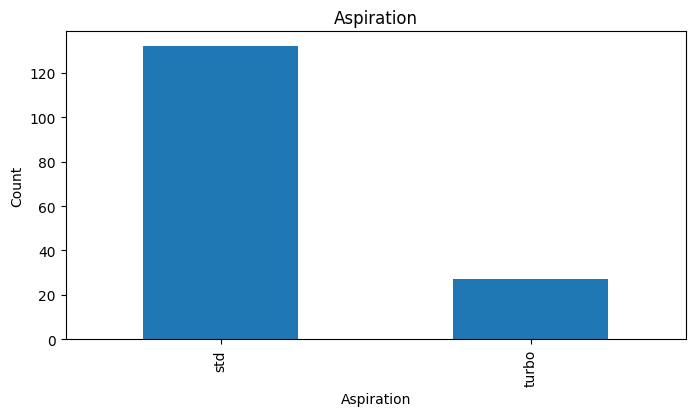

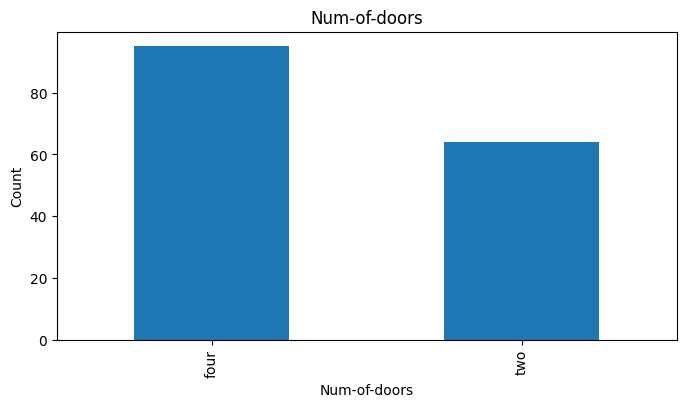

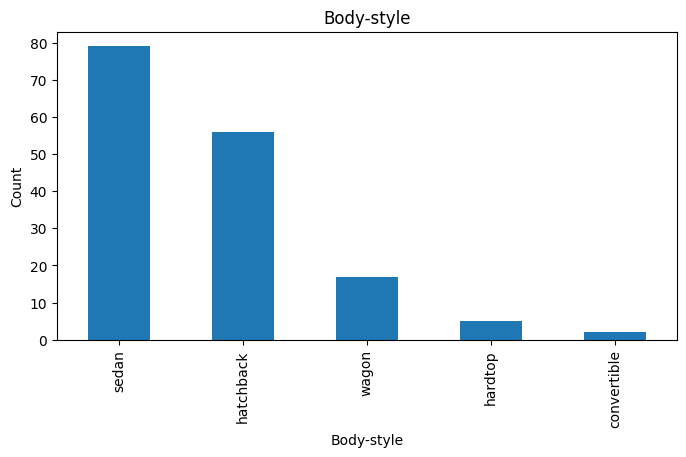

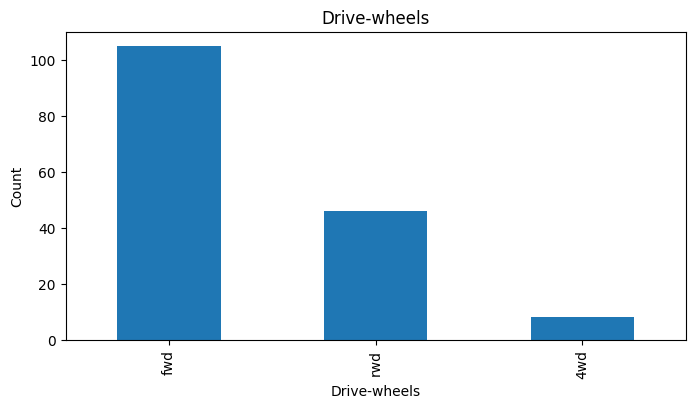

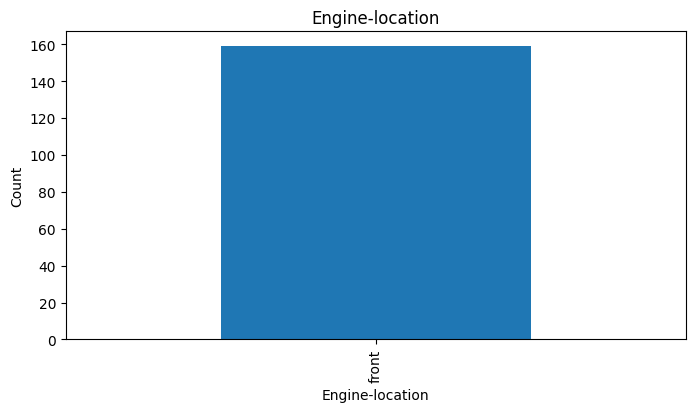

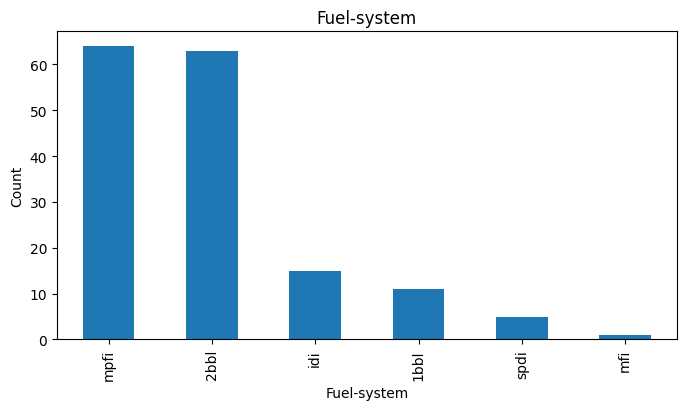

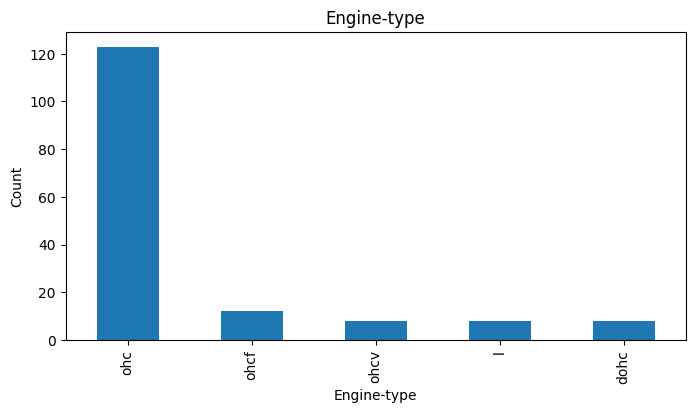

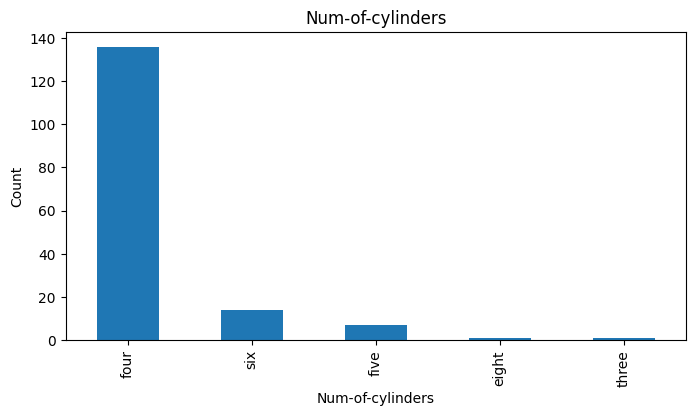

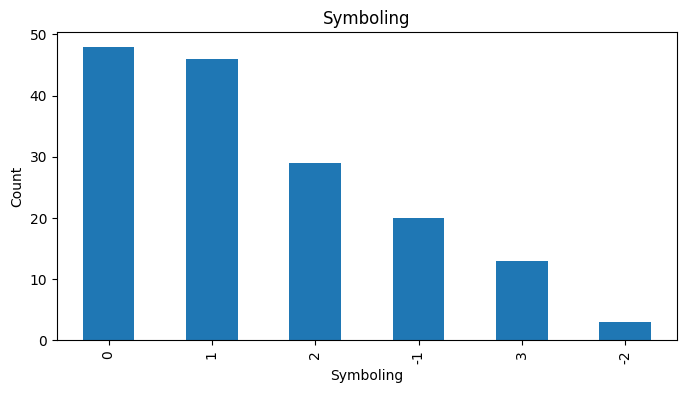

In [ ]:
categorical_columns = ['Make', 'Fuel-type', 'Aspiration', 'Num-of-doors',
                       'Body-style', 'Drive-wheels', 'Engine-location', 'Fuel-system', 'Engine-type', 'Num-of-cylinders', 'Symboling']

for col in categorical_columns:
    df_without_na[col].value_counts().plot(kind='bar', figsize=(8, 4), title=col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Predict missing values

In [ ]:
random_seed = 42

In [ ]:
# Predict numerical values
columns_with_missing_values = ['Normalized-losses', 'Bore', 'Stroke', 'Horsepower', 'Peak-rpm', 'Price']

for col in columns_with_missing_values:
    df_without_na = df.dropna(subset=[col])
    X = df_without_na[numerical_columns].drop(columns=[col])
    y = df_without_na[col]

    X_missing = df[df[col].isnull()][numerical_columns].drop(columns=[col])

    model = RandomForestRegressor(random_state=random_seed)

    model.fit(X, y)

    predicted_values = model.predict(X_missing)

    print(f"Predicted values for '{col}':")
    print(predicted_values)

    df.loc[df[col].isnull(), col] = model.predict(X_missing)

Predicted values for 'Normalized-losses':
[180.39       156.465      108.14        97.868      140.81
 156.955      134.11       134.37       186.06333333 145.18
 128.72       117.91       156.465      124.93       113.62
 166.84       104.72       162.826      122.89       140.2
  93.31        95.828      112.63       147.67       110.9
 125.61       120.34       163.62       163.666      127.32
 114.57       187.926      156.955      125.03       188.
 163.696      112.99       129.41       162.98       137.91
 129.79      ]
Predicted values for 'Bore':
[3.0712 3.0661 3.0712 3.0682]
Predicted values for 'Stroke':
[3.2651 3.2651 3.2654 3.1787]
Predicted values for 'Horsepower':
[96.47 96.25]
Predicted values for 'Peak-rpm':
[4899.5 4937. ]
Predicted values for 'Price':
[ 6143.59 18822.13  6237.65 36854.94]


In [ ]:
# Mode Imputation for categorical features
columns_with_missing_values = ['Num-of-doors']

for col in columns_with_missing_values:
    missing_rows = df[df[col].isnull()]
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-230-8b078c878760>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [ ]:
# check for missing values
print(df.isnull().sum())

Normalized-losses    0
Make                 0
Fuel-type            0
Aspiration           0
Num-of-doors         0
Body-style           0
Drive-wheels         0
Engine-location      0
Wheel-base           0
Length               0
Width                0
Height               0
Curb-weight          0
Engine-type          0
Num-of-cylinders     0
Engine-size          0
Fuel-system          0
Bore                 0
Stroke               0
Compression-ratio    0
Horsepower           0
Peak-rpm             0
City-mpg             0
Highway-mpg          0
Price                0
Symboling            0
dtype: int64


# Feature and Target selection

In [ ]:
# Normalization
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [ ]:
# One-hot encoding
categorical_columns = ['Engine-type', 'Num-of-cylinders', 'Make', 'Fuel-type', 'Aspiration', 'Num-of-doors',
                       'Body-style', 'Drive-wheels', 'Engine-location', 'Fuel-system']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

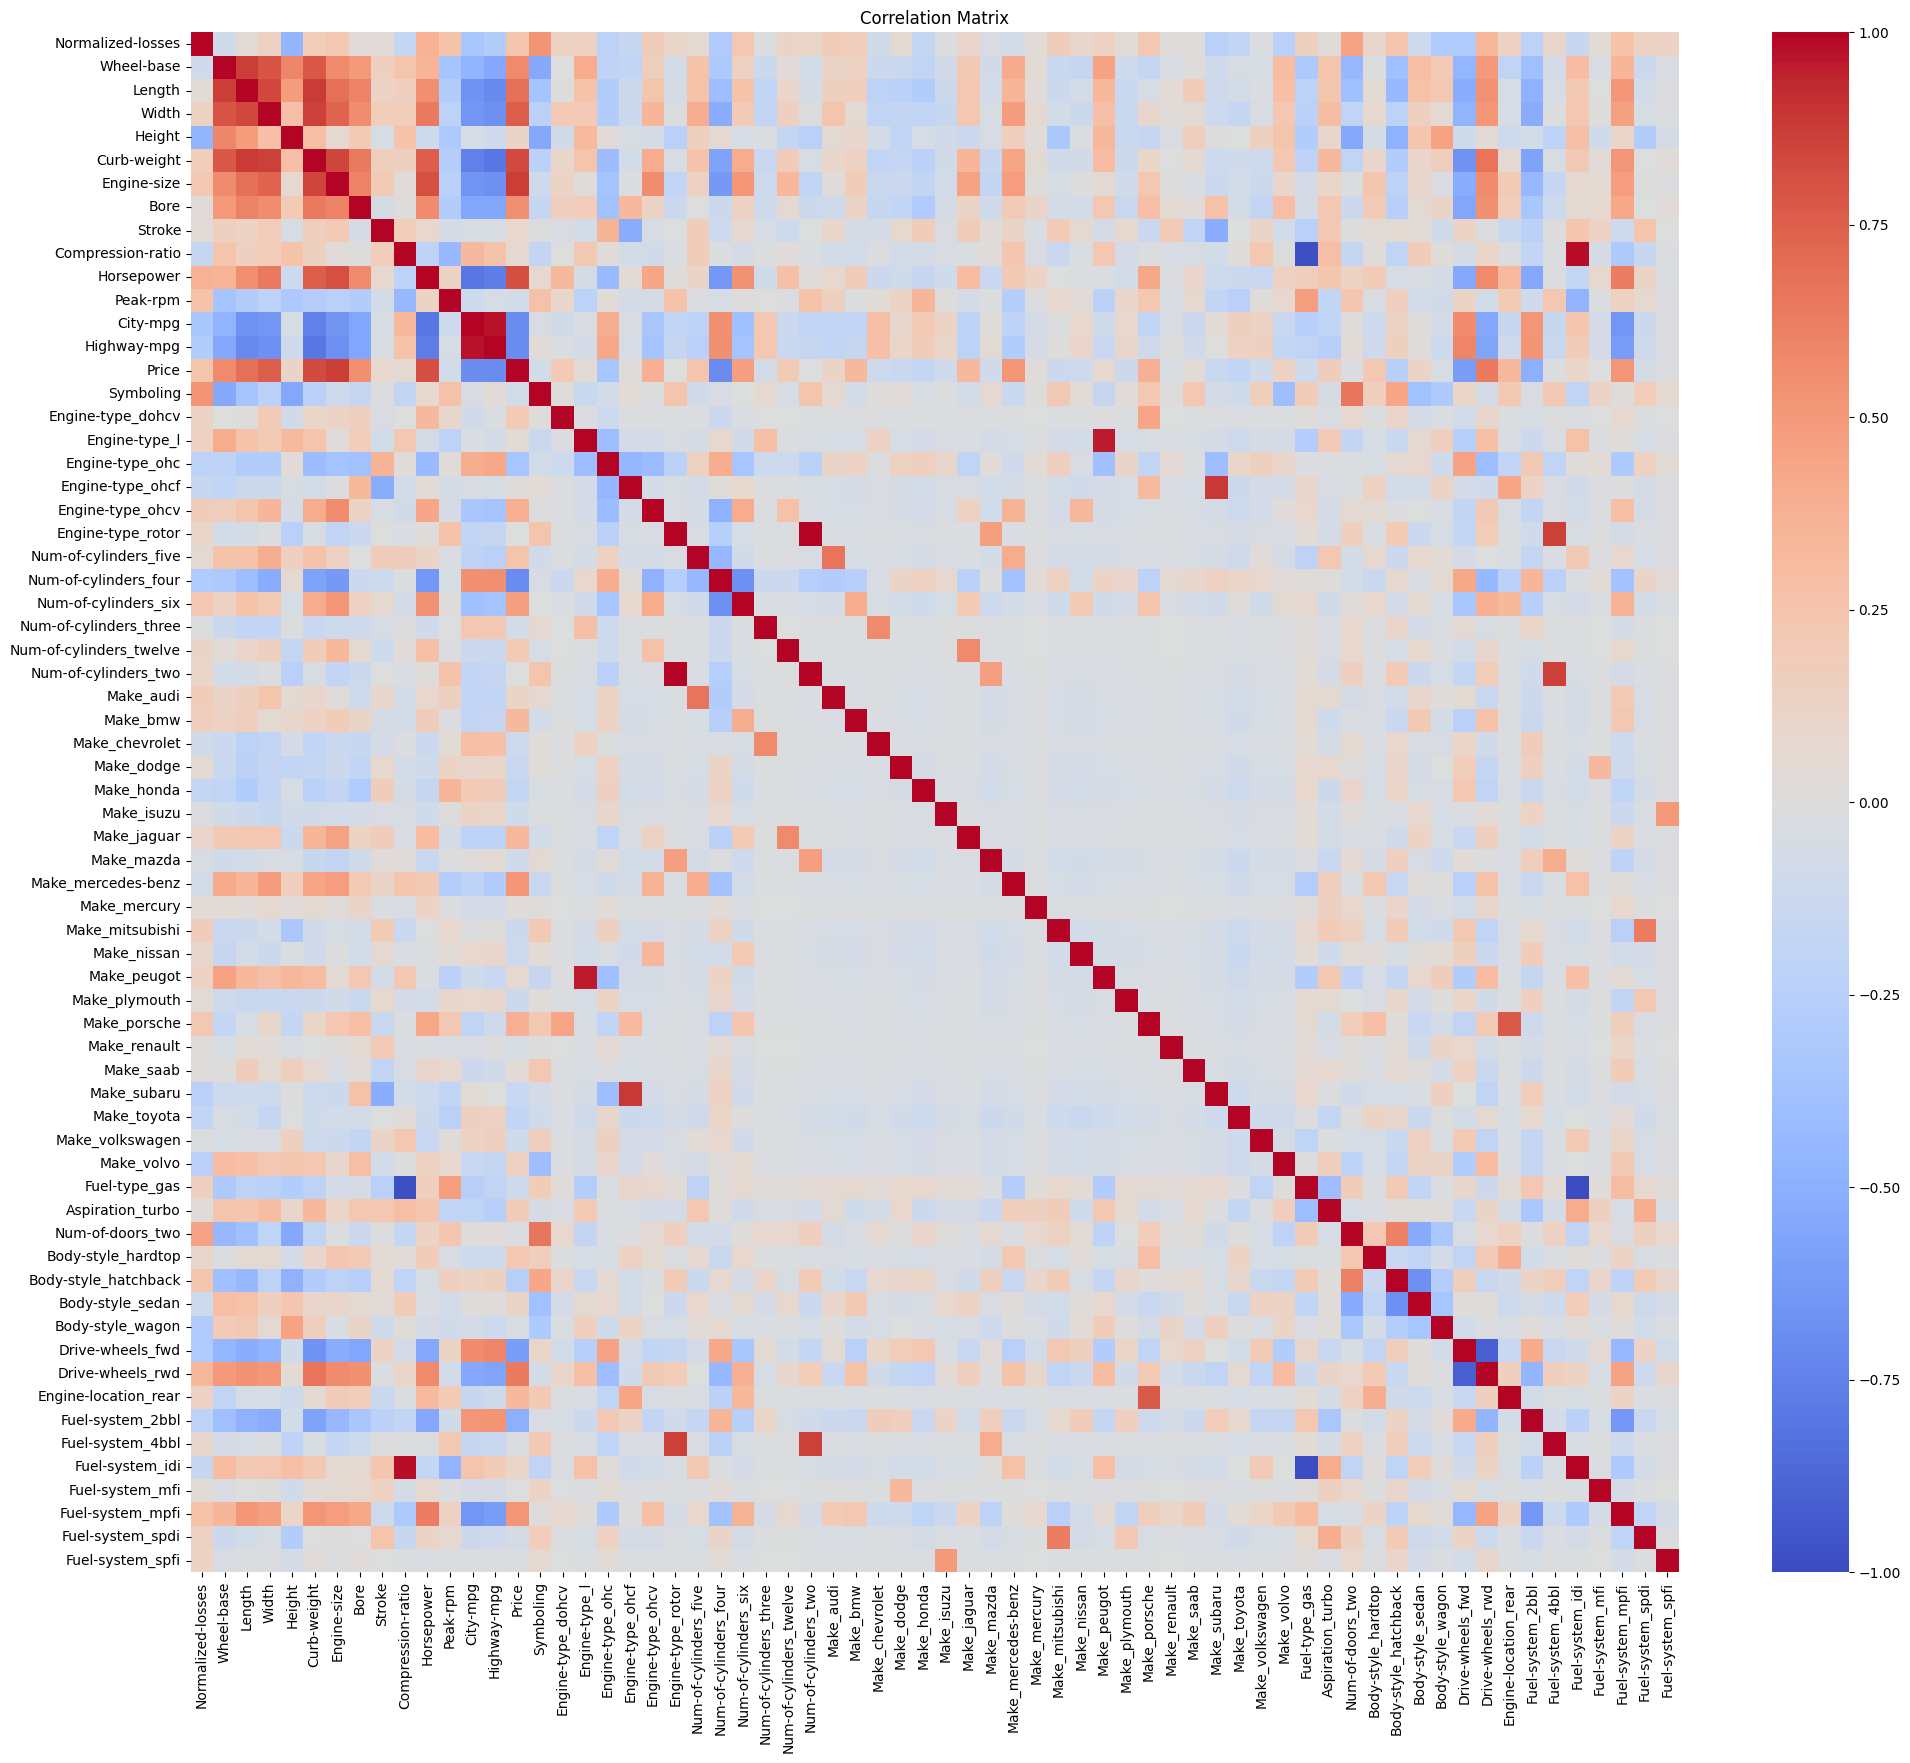

In [ ]:
corr = df.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title("Correlation Matrix")
plt.show()

In [ ]:
df.head()

,Normalized-losses,Wheel-base,Length,Width,Height,Curb-weight,Engine-size,Bore,Stroke,Compression-ratio,...,Drive-wheels_fwd,Drive-wheels_rwd,Engine-location_rear,Fuel-system_2bbl,Fuel-system_4bbl,Fuel-system_idi,Fuel-system_mfi,Fuel-system_mpfi,Fuel-system_spdi,Fuel-system_spfi
0,1.252131,-0.708596,-0.434647,-0.891512,-0.461478,-0.744242,-0.695874,-0.494053,-0.719740,-0.288349,...,False,True,False,True,False,False,False,False,False,False
1,-0.355381,-0.941655,-0.589028,-0.798053,0.153893,-1.165875,-0.864383,-0.897610,-0.336205,-0.288349,...,True,False,False,True,False,False,False,False,False,False
2,-1.115296,-0.508831,-1.247182,-1.078431,0.317992,-1.098491,-0.840310,-1.007671,-0.719740,-0.288349,...,True,False,False,True,False,False,False,False,False,False
3,-0.004651,-0.408949,-0.134009,-0.237296,-0.871725,-0.366890,-0.118132,0.092940,0.654592,-0.414537,...,True,False,False,True,False,False,False,False,False,False
4,0.667581,-0.841772,-1.360937,-0.984972,-1.281972,-0.701886,-0.695874,-1.081045,0.430864,-0.641675,...,True,False,False,False,False,False,False,True,False,False


# Split labeled data

In [ ]:
X = df.drop('Symboling', axis=1)  # Features
y = df['Symboling']               # Target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, shuffle=True, stratify=y)

In [ ]:
# Handling class imbalance
smote = SMOTE(random_state=random_seed,k_neighbors=1)
X_train, y_train = smote.fit_resample(X, y)

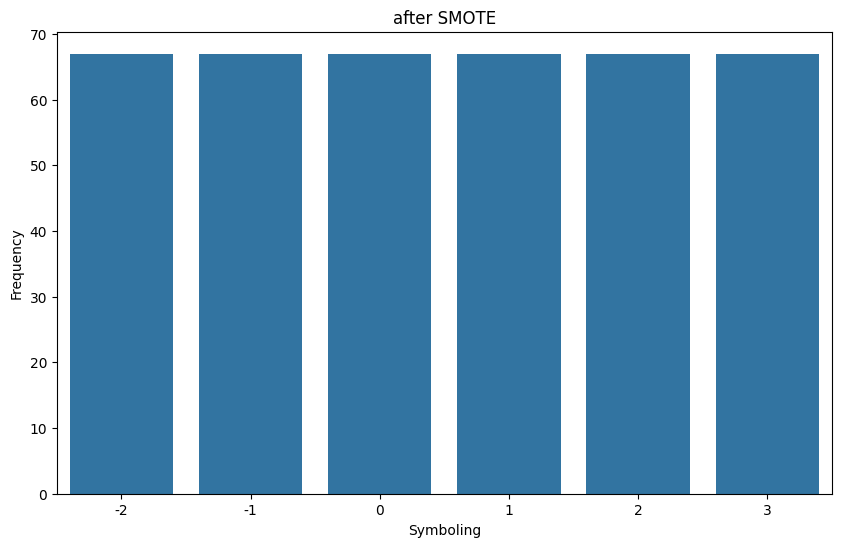

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('after SMOTE')
plt.xlabel('Symboling')
plt.ylabel('Frequency')
plt.show()

# Training

In [ ]:
model1 = RandomForestClassifier(random_state=random_seed)
model2 = KNeighborsClassifier()
model3 = LogisticRegression(max_iter=1000, random_state=random_seed)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

rf_predictions = model1.predict(X_test)
knn_predictions = model2.predict(X_test)
log_reg_predictions = model3.predict(X_test)
print(f"\nRandom Forest Classifier:\n{classification_report(y_test, rf_predictions)}")

print(f"\nK-Neighbors Classifier:\n{classification_report(y_test, knn_predictions)}")

print(f"\nLogistic Regression Classifier:\n{classification_report(y_test, log_reg_predictions)}")

print(f"\nAccuracy for:\nRandom Forest: {accuracy_score(y_test, rf_predictions)}\nK-Neighbors: {accuracy_score(y_test, knn_predictions)}\nLogistic Regression: {accuracy_score(y_test, log_reg_predictions)}")


Random Forest Classifier:
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00         1
          -1       1.00      1.00      1.00         4
           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41


K-Neighbors Classifier:
              precision    recall  f1-score   support

          -2       0.50      1.00      0.67         1
          -1       0.80      1.00      0.89         4
           0       0.83      0.77      0.80        13
           1       1.00      0.64      0.78        11
           2       0.78      1.00      0.88         7
           3       0.83      1.00      0.91         5

    accuracy             

Random Forest Classifier performs the best

# Hyperparameter tuning

For Random Forest Classifier

In [ ]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist_knn,
                                       n_iter=100, cv=5, random_state=random_seed, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'metric': 'euclidean', 'leaf_size': 20, 'algorithm': 'ball_tree'}


In [ ]:
best_knn_model = KNeighborsClassifier(
    n_neighbors=random_search.best_params_['n_neighbors'],
    weights=random_search.best_params_['weights'],
    algorithm=random_search.best_params_['algorithm'],
    leaf_size=random_search.best_params_['leaf_size'],
    p=random_search.best_params_['p'],
    metric=random_search.best_params_['metric'],
)

best_knn_model.fit(X_train, y_train)

knn_predictions = best_knn_model.predict(X_test)

print("K-Neighbors with Best Parameters:")
print(classification_report(y_test, knn_predictions))
print("Accuracy:", accuracy_score(y_test, knn_predictions))

K-Neighbors with Best Parameters:
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00         1
          -1       1.00      1.00      1.00         4
           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Accuracy: 1.0


As we can see, the accuracy improved and became perfect for K-Neighbors Classifier.

# Discussion

Random Forest has the highest accuracy among all 3 models (100%), which is an insanely interesting behaviour. It means that the model is perfect, but considering the imbalanced distribution in the test set (there is only one instance of the class -2), it is arguable.

K-Neighbors has the worst metrics before the hyperparameter tuning. The previous version performs well, but it struggles with the class -2. The precision of this class is 0.5, which indicates the fact that other classes are misclassified as -2. The new version has a precision of 100%.

Logistic Regression performs better than the old K-Neighbors model. Overall the metrics are fine, but the recall for the class 2 is 0.71, which indicates the fact that this class tends to be misclassified into other classes more frequently than the other ones.

I think that an evaluation on a larger and more balanced dataset would provide better insights on the models’ performance.